
# ERT field data with Topography

using Tom's data! For line 01.

First adding our imports.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.physics import ert
import os

Now call the data file and load it.

In [ ]:
os.chdir(r'C:\Users\sydne\git\erth370\erth370-w2026-sydpas')
print(f'Directory of figures: {os.getcwd()}')  # shows your current working directory
os.makedirs(r"figures/line09", exist_ok=True)

filename = r'C:\Users\sydne\git\erth370\erth370-w2026-sydpas\data\line09\Line09_DD_Grad10m_TOPO_combined.dat'
data = ert.load(filename)
print(data)

Let us first have a look at the topography contained in the data!

From chat explanation: "...we are interpolating the elevation at each electrode’s x-position by linearly estimating between the nearest topo points. This is done because the DAT file gives topography points at certain x-locations (say, [9.6, 14.7, 19.7, ...]), but electrodes might be at [0, 5, 10, 15, 20, ..., 400]."

In [ ]:
topo = []
start_topo = False

with open(filename) as f: 
    for line in f:
        line = line.strip()
        if "Topography in a separate list" in line:
            start_topo = True; continue
        if start_topo:
            parts = line.split()  # split using whitespace
            if len(parts) == 2:  # if data has 2 columns it is topo data so add to the list
                topo.append([float(parts[0]), float(parts[1])])

topo = np.array(topo)  # convert to numpy array

x_elec = pg.x(data)  # get x pos of all electrodes
z_elec = np.interp(x_elec, topo[:,0], topo[:,1])  # interpolate topo at each electrode

x_elec = np.array(pg.x(data))  # convert RVector to numpy

# now we ensure topo covers all electrodes at both ends
if topo[0,0] > x_elec.min():  # if topo is to the right of (after) electrode
    topo = np.vstack(([x_elec.min(), topo[0,1]], topo))
if topo[-1,0] < x_elec.max():  # if topo is to the left of (before) electrode
    topo = np.vstack((topo, [x_elec.max(), topo[-1,1]]))


# second interp of topo at electrode positions
z_interp = np.interp(x_elec, topo[:,0], topo[:,1])

# set electrode positions in data
data.setSensorPositions(pg.PosVector(np.c_[x_elec, z_interp]))  # combine into 2D array, convert to gimli pos vector, and update elec pos in ERT dataset

# plot to check
fig, ax = plt.subplots(figsize=(10,4)) 
ax.plot(x_elec, z_interp, 'r*')
ax.set_xlabel('Electrode Location [m]')
ax.set_ylabel('Elevation [m]')
ax.set_title('Topography')

fig.savefig(r"figures/line09/topography.png", dpi=300, bbox_inches='tight') 
plt.show()


The data file does not contain geometric factors (token field 'k'),
so we create them based on the given topography.

from chat: "K converts measured resistance to apparent resistivity.
- Analytical: assumes flat ground and ideal geometry, so less accurate.
- Numerical: solves with PDE and uses real electrode positions and topography."


In [ ]:
# topo= pg.PosVector(topo)  # turn from array into pygimli pos vector

k0 = ert.createGeometricFactors(data)  # analytical; assumes simple geometry
data['k'] = ert.createGeometricFactors(data, numerical=True)  # numerical; solves forward PDE

It might be interesting to see the topography effect, i.e the ratio between
the numerically computed geometry factor and the analytical formula after
Rücker et al. (2006). We display it using a colormap with neutral white.

from chat: "Topographic effect on resistivity
- ~1: topo has little effect
- topo > 1: ignoring topo overestimates resistivity
- topo < 1: ignoring topo underestimates resistivity"

bwr colormap directory:
- blue: high numerical k
- red: high analytical k
- white: same

Pseudo-depth: sensitivity location.
- DD: dipole dipole.
- Numbers: electrode spacing levels. 
    - Current: controls how deep the current penetrates (A-B)
    - Potential: controls voltage sensitivity (M-N).
- ex. DD2-3:
    - current dipole spacing: 2 electrodes.
    - potential dipole spacing: 3 electrodes. 

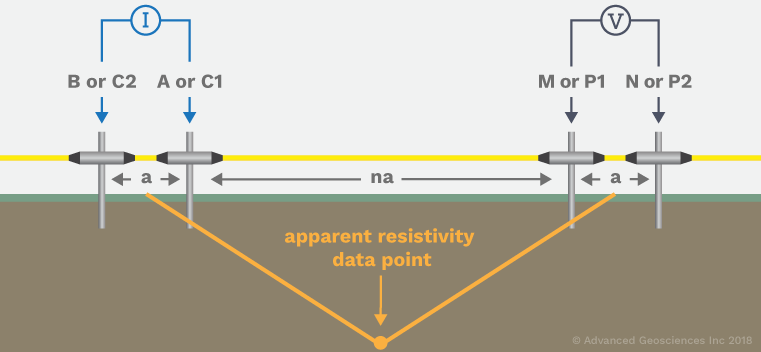
https://www.agiusa.com/dipole-dipole%E2%80%8B-%E2%80%8Barray%E2%80%8B

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
_ = ert.showData(data, 
                 vals=k0/ data['k'],  # quantifies the topography effect
                 ax=ax,
                 label='Topography effect', xlabel='Distance [m]', ylabel='Pseudo-depth',
                 cMin=2/3, cMax=3/2,  # color limits
                 logScale=True, 
                 cMap="bwr"  # blue-white-red colormap
)

ax.set_title('Topography Effect on Data');

fig.savefig(r"figures/line09/topo_effect_on_data.png", dpi=300, bbox_inches='tight')


We can now compute the apparent resistivity and display it, once with the
wrong analytical formula and once with the numerical values in data['k']



In [ ]:
data['rhoa'] = data['r'] * data['k']  # uses numerical k; converts measured resistances to apparent resist

# edit impossible negative or zero values
data['rhoa'][data['rhoa'] <= 0] = 1e-6

cmin = pg.min(data['rhoa'])
cmax = pg.max(data['rhoa'])
print(f' Min: {pg.min(data["rhoa"])}, Max: {pg.max(data["rhoa"])}')

kw = dict(cMin=cmin, cMax=cmax)  # storing key/value pairs for colour scale
fig, ax = plt.subplots(ncols=2, figsize=(14, 8))

data.show(data['r']*k0, ax=ax[0], **kw, cMap='inferno', 
          xlabel='Distance [m]', ylabel='Pseudo-depth');  # uses analytical k so assumes flat ground

data.show(ax=ax[1], **kw, cMap='inferno',
          xlabel='Distance [m]')  # uses numerical k so adds topo

ax[0].set_title('Analytical Geometric Factor; Uncorrected')  # analytical
ax[1].set_title('Numerical Geometric Factor; Corrected');  # numerical 

fig.savefig(r"figures/line09/uncorrected_vs_corrected.png", dpi=300, bbox_inches='tight')


The data container does not necessarily contain data errors data errors
(token field 'err'), requiring us to enter data errors. We can let the
manager guess some defaults for us automatically or set them manually



In [ ]:
data.estimateError(relativeError=0.03, absoluteUError=5e-5)

fig, ax = plt.subplots(figsize=(8,8))
_ = data.show( data['err']*100, ax=ax,
    label='error estimate (%)', xlabel='Distance [m]',
    cMin=3, cMax=25)

ax.set_title('Estimated Data Error');

fig.savefig(r"figures/line09/data_error.png", dpi=300, bbox_inches='tight')


We initialize the ERTManager for further steps and eventually inversion.



In [ ]:
mgr = ert.ERTManager(data)

Now the data have all necessary fields ('rhoa', 'err' and 'k') so we can run
the inversion. The inversion mesh will be created with some optional values
for the parametric mesh generation.




In [ ]:
os.chdir(r"C:\Users\sydne\git\erth370\erth370-w2026-sydpas\pygimex\ert\extra_files\line09")

mod = mgr.invert(data, lam=10, verbose=True,
                 paraDX=0.3, paraMaxCellSize=10, paraDepth=20, quality=33.6)
ax, cb = mgr.showResult()

fig.savefig(r"figures/line09/inversion_result.png", dpi=300, bbox_inches='tight')

We can view the resulting model in the usual way.



In [ ]:
_ = mgr.showResultAndFit()

fig.savefig(r"figures/line09/invers_data_response.png", dpi=300, bbox_inches='tight')

Or just plot the model only using your own options.



In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax, cb = mgr.showResult(mod, ax=ax, cMin=70, cMax=3150, cMap="Spectral_r",logScale=True)

ax.set_xlabel("Distance [m]")
ax.set_ylabel("Elevation [m]")
ax.set_title("Inversion Result (Apparent Resistivity)");

fig.savefig(r"figures/line09/inver_app_resistivity.png", dpi=300, bbox_inches='tight')